# Deep learning Sentiment analysis(or opinion mining)
The goal of this project is to be able to consistently detect emotions in normal conversational sentences , help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.

# Load Libraries

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

# Loading dataset 
using twitter dataset that is List of documents with emotion flag, It is split into train, test & validation for building the machine learning model, It helps greatly in NLP Classification tasks

In [2]:
df_train= pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_val= pd.read_csv('val.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test= pd.read_csv('test.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

df_dataset=pd.read_csv('dataset.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

In [3]:
df_dataset['Sentiment'].value_counts()

joy         6752
sadness     5789
anger       2706
fear        2370
love        1639
surprise     719
Name: Sentiment, dtype: int64

In [5]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Plotting data

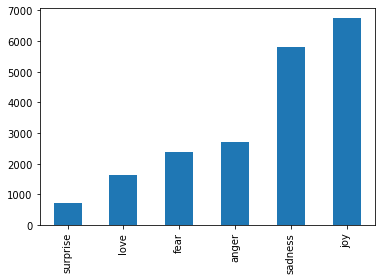

In [6]:
df_dataset['Sentiment'].value_counts().sort_values().plot.bar()
plt.show()

In [7]:
x= df_train['Input']

In [9]:
# calculating the length of each message and making into a dataframe
lst=[]
for i in x:
  lst.append(len(i))

In [10]:
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

culc the num of element that have same length in the list

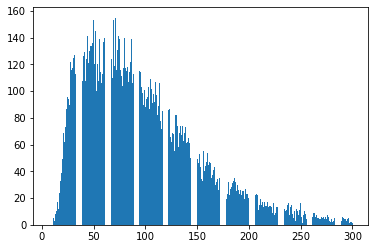

In [11]:
plt.bar(range(7, 301), cts)
plt.show()

# Preprocessing
- Punctuation Removal
- Case Normalization
- Remove Stopwords
- Lemmatization

In [12]:
def Preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = [w for w in text.split(' ') if w not in stopwords.words('english')]
    text = [WordNetLemmatizer().lemmatize(token) for token in text]
    text = [WordNetLemmatizer().lemmatize(token,pos='v') for token in text]
    text = " ".join(text)
    return text

df_train['Input'] = df_train.Input.apply(lambda x:Preprocessing(x))
df_val['Input'] = df_val.Input.apply(lambda x:Preprocessing(x))
df_test['Input']= df_test.Input.apply(lambda x:Preprocessing(x))



# Tokenizing 
Word tokenization is the process of splitting a large sample of text into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis like classifying and counting them for a particular sentiment etc.

In [18]:
# Tokenizing training data set
tokenizer= Tokenizer(1512, lower=True, oov_token='UNK') #num_words=1512
tokenizer.fit_on_texts(x)

In [19]:
# Convert text to sequences using keras
x_train= tokenizer.texts_to_sequences(x)

In [20]:
# Pad sequences to get uniform length
x_train_pad= pad_sequences(x_train, maxlen=80, padding='post')

# One hot encoding string values
Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. This means that categorical data must be converted to a numerical form.

- Integer Encoding As a first step, each unique category value is assigned an integer value. For example, “joy” is 1, “anger” is 2, and “sadness” is 3. For some variables, this may be enough. The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

- One-Hot Encoding For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

### Training data

In [21]:
# Replace the sentiments with numbers in JSON format
df_train['Sentiment']= df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [22]:
y_train= df_train['Sentiment'].values
print(y_train[:4])

[3 3 1 2]


In [23]:
# Convert to binary matrix
y_train_f= to_categorical(y_train)

In [24]:
# Printing first four rows of matrix
y_train_f[:4]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

### Validation data


In [25]:
# Perform same steps as training data set
x_val= df_val['Input']

In [26]:
y_val= df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [27]:
x_val_f= tokenizer.texts_to_sequences(x_val)

In [28]:
x_val_pad= pad_sequences(x_val_f, maxlen=80, padding='post')

In [29]:
y_val_f= to_categorical(y_val)

### Test dataset

In [36]:
# Same steps as training/ validation dataset 
x_test= df_test['Input']

In [37]:
y_test= df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [38]:
x_test_f= tokenizer.texts_to_sequences(x_test)

In [39]:
x_test_pad= pad_sequences(x_test_f, maxlen=80, padding='post')

In [40]:
y_test_f= to_categorical(y_test)

# Creating the LSTM Model 

In [30]:
# Instantiating the keras model to be Sequential
model= Sequential()

# Adding first hidden layer
model.add(Embedding(15212, 64, input_length=80)) #input_dim=15212, output_dim=64

# Dropout technique to prevent overfitting
model.add(Dropout(0.6))

# Creating LSTM layer
model.add(Bidirectional(LSTM(80, return_sequences= True))) #units=80 dimensionality of the output space.

model.add(Bidirectional(LSTM(70)))

# Adding final hidden layer
model.add(Dense(6, activation='softmax')) #6 is output units, use 2 in IMDB dataset

# Printing model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            973568    
                                                                 
 dropout_1 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 140)              129360    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 846       
                                                                 
Total params: 1,196,574
Trainable params: 1,196,574
No

# Compiling the model

In [31]:
# Compiling model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Building and training the model
hist= model.fit(x_train_pad, y_train_f, epochs=24, batch_size=128, validation_data=(x_val_pad, y_val_f)) 

Epoch 1/24
125/125 [==============================] - 55s 358ms/step - loss: 1.4930 - accuracy: 0.4060 - val_loss: 1.0674 - val_accuracy: 0.5900
Epoch 2/24
125/125 [==============================] - 56s 445ms/step - loss: 0.8449 - accuracy: 0.6996 - val_loss: 0.6418 - val_accuracy: 0.7745
Epoch 3/24
125/125 [==============================] - 64s 510ms/step - loss: 0.5460 - accuracy: 0.8117 - val_loss: 0.4389 - val_accuracy: 0.8460
Epoch 4/24
125/125 [==============================] - 70s 561ms/step - loss: 0.4028 - accuracy: 0.8605 - val_loss: 0.3620 - val_accuracy: 0.8685
Epoch 5/24
125/125 [==============================] - 67s 533ms/step - loss: 0.3323 - accuracy: 0.8796 - val_loss: 0.3397 - val_accuracy: 0.8665
Epoch 6/24
125/125 [==============================] - 66s 528ms/step - loss: 0.2875 - accuracy: 0.8961 - val_loss: 0.3177 - val_accuracy: 0.8755
Epoch 7/24
125/125 [==============================] - 77s 617ms/step - loss: 0.2552 - accuracy: 0.9056 - val_loss: 0.2731 - val_ac

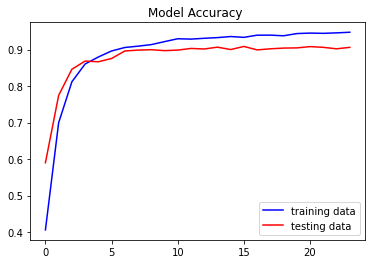

In [33]:
# Plotting accuracy of training vs validation
plt.plot(hist.history['accuracy'], c='b', label='training data')
plt.plot(hist.history['val_accuracy'], c='r', label='testing data')
plt.legend(loc='lower right')
plt.title('Model Accuracy ')
plt.show()

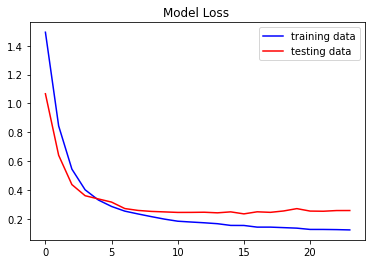

In [34]:
# Plotting loss of training vs validation
plt.plot(hist.history['loss'], c='b', label='training data')
plt.plot(hist.history['val_loss'], c='r', label='testing data')
plt.legend(loc='upper right')
plt.title('Model Loss ')
plt.show()

# Evaluating the performance of the model
Accuracy

In [41]:
# Evaluate model
model.evaluate(x_test_pad, y_test_f)

#model.evaluate(x_test_pad2, y_test_f2)

63/63 [==============================] - 2s 32ms/step - loss: 0.2466 - accuracy: 0.9030


[0.24664759635925293, 0.902999997138977]

# Predict model

In [43]:
# Predict model for test data
predict_x=model.predict(x_test_pad) 
classes_x=np.argmax(predict_x,axis=1)



# Classification Report


In [44]:
# Print precision, recall & f1 score
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1: 2 tp / (2 tp + fp + fn)

from sklearn.metrics import classification_report
print("")
print(classification_report(y_test, classes_x))


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       695
           1       0.88      0.89      0.88       275
           2       0.76      0.84      0.80       159
           3       0.94      0.94      0.94       581
           4       0.90      0.87      0.88       224
           5       0.76      0.76      0.76        66

    accuracy                           0.90      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.90      0.90      0.90      2000



# Save model

In [45]:
#Save keras model
from keras.models import save_model
import os.path
if os.path.isfile('my_model') is False :
    model.save('my_model')

# To load the model:
from keras.models import load_model
saved_mdl = load_model("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [46]:
# Evaluate saved model
saved_mdl.evaluate(x_test_pad, y_test_f)

63/63 [==============================] - 19s 40ms/step - loss: 0.2466 - accuracy: 0.9030


[0.24664759635925293, 0.902999997138977]

In [47]:
# Printing saved model summary
print(saved_mdl.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            973568    
                                                                 
 dropout_1 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 140)              129360    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 846       
                                                                 
Total params: 1,196,574
Trainable params: 1,196,574
No

# Playground

In [48]:
def startAnalysis(INPUT):
    
    x_ = np.array([INPUT])
    # Convert text to sequences using keras
    x_input = tokenizer.texts_to_sequences(x_)
    # Pad sequences to get uniform length
    x_input_pad= pad_sequences(x_input, maxlen=80, padding='post')

    predict_input=saved_mdl([x_input_pad])
    classes_=np.argmax(predict_input,axis=1)

    categories = ['joy','anger','love','sadness','fear','surprise']
    OUTPUT= categories[int(classes_)]
    return OUTPUT

In [56]:
print (startAnalysis("let's have fun"))

joy


In [62]:
print (startAnalysis("Today, my father told me, “Just go for it and give it a try!\
You don’t have to be a professional to build a successful product."))

joy


In [64]:
print (startAnalysis ("Today, after I watched my dog get run over by a car, I sat on the side of the road \
holding him and crying. And just before he died, he licked the tears off my face."))

fear


In [65]:
print (startAnalysis ("Today, I kissed my dad on the forehead as he passed away in a small hospital bed.\
About 5 seconds after he passed, I realized it was the first time I had given him a kiss since I was a little boy."))

sadness
